In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("../input/padhai-module1-assignment/train.csv")
test = pd.read_csv("../input/padhai-module1-assignment/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Sim1', 'RAM', 'Screen to Body Ratio (calculated)',
       'Num_cores', 'SIM 2', 'SIM Slot(s)', 'Pixel Density', 'Capacity',
       'Weight', 'Processor_frequency', 'Screen Size', 'Brand', 'Height',
       'Internal Memory', 'Resolution', 'os_name'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'RAM', 'Screen to Body Ratio (calculated)', 'Pixel Density',
       'Capacity', 'Weight', 'Processor_frequency', 'Screen Size', 'Height',
       'Internal Memory', 'Resolution', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G',
       'Num_cores_312', 'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa',
       'Num_cores_Octa', 'Num_cores_Other', 'Num_cores_Quad',
       'Num_cores_Tru-Octa', 'SIM 2_2G', 'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other',
       'SIM Slot(s)_Dual SIM, GSM+CDMA', 'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple',
       'Brand_Asus', 'Brand_Billion', 'Brand_B

In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [15]:
# save the cleaned csv 
train_new.to_csv("train_cleaned.csv", index=False)
test_new.to_csv("test_cleaned.csv", index=False)

In [16]:
test_new.head()

,PhoneId,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,...,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,3,2,80.85,271,4230,168,1.8,6.20,156.2,16,...,0,0,0,1,0,0,0,0,0,0
1,11,4,81.60,402,5000,205,1.8,6.20,156.0,64,...,0,0,0,1,0,0,0,0,0,0
2,13,6,83.84,409,3500,169,2.0,6.30,156.7,64,...,0,0,0,1,0,0,0,0,0,0
3,16,4,83.84,409,3500,169,2.0,6.30,156.7,64,...,0,0,0,1,0,0,0,0,0,0
4,19,4,77.43,403,4000,181,1.8,5.99,158.6,64,...,0,0,0,1,0,0,0,0,0,0


In [17]:
train_new.head()

,PhoneId,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,...,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Rating
0,0,4,80.68,403,4000,182,1.8,6.26,157.9,64,...,0,0,1,0,0,0,0,0,0,4.5
1,1,3,80.85,271,4230,168,1.8,6.20,156.2,32,...,0,0,1,0,0,0,0,0,0,4.5
2,2,3,83.68,409,3500,168,2.1,6.30,157.0,32,...,0,0,1,0,0,0,0,0,0,4.4
3,4,4,74.78,411,3300,169,2.2,6.00,159.8,64,...,0,0,1,0,0,0,0,0,0,4.3
4,5,4,84.23,396,3750,175,2.2,6.50,160.4,64,...,0,0,1,0,0,0,0,0,0,4.4


In [18]:
train_new.describe()

,PhoneId,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,...,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,11.120235,72.353343,344.211144,3191.307918,161.343109,1.792551,5.462317,149.946394,46.369501,...,0.011730,0.002933,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,4.072434
std,137.231746,61.320855,9.357839,88.161129,932.533527,22.305556,0.451598,0.742529,9.192305,46.435453,...,0.107827,0.054153,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.377066
min,0.000000,1.000000,23.600000,143.000000,1020.000000,58.000000,1.000000,2.400000,115.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000
25%,110.000000,2.000000,68.800000,282.000000,2900.000000,150.000000,1.400000,5.200000,146.200000,16.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000
50%,229.000000,3.000000,72.500000,326.000000,3055.000000,161.000000,1.800000,5.500000,151.300000,32.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.100000
75%,354.000000,4.000000,77.480000,403.000000,3750.000000,172.000000,2.200000,6.000000,156.200000,64.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.300000
max,472.000000,512.000000,87.660000,576.000000,13000.000000,330.000000,2.800000,6.590000,174.100000,512.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [19]:
train_new.shape

(341, 88)

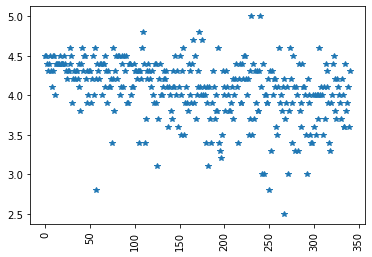

In [20]:
plt.plot(train_new['Rating'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [21]:
train_new['Rating'] = train_new['Rating'].map(lambda x: 0 if x<=THRESHOLD else 1)

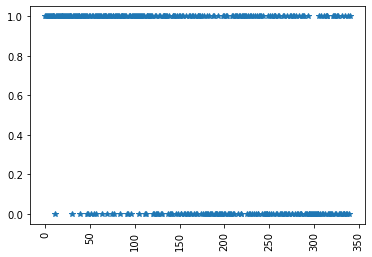

In [22]:
plt.plot(train_new['Rating'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [23]:
train_new.head(20)

,PhoneId,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,...,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Rating
0,0,4,80.68,403,4000,182,1.80,6.26,157.90,64,...,0,0,1,0,0,0,0,0,0,1
1,1,3,80.85,271,4230,168,1.80,6.20,156.20,32,...,0,0,1,0,0,0,0,0,0,1
2,2,3,83.68,409,3500,168,2.10,6.30,157.00,32,...,0,0,1,0,0,0,0,0,0,1
3,4,4,74.78,411,3300,169,2.20,6.00,159.80,64,...,0,0,1,0,0,0,0,0,0,1
4,5,4,84.23,396,3750,175,2.20,6.50,160.40,64,...,0,0,1,0,0,0,0,0,0,1
5,7,6,84.98,402,3400,156,2.20,6.41,157.90,64,...,0,0,1,0,0,0,0,0,0,1
6,8,2,72.68,295,3000,145,2.00,5.45,147.50,16,...,0,0,1,0,0,0,0,0,0,1
7,9,3,79.24,432,4000,178,2.00,5.84,149.30,32,...,0,0,1,0,0,0,0,0,0,1
8,10,2,80.85,271,4230,168,1.80,6.20,156.20,16,...,0,0,1,0,0,0,0,0,0,1
9,12,6,82.20,403,4000,182,2.80,6.18,155.50,64,...,0,0,1,0,0,0,0,0,0,1


In [24]:
ratings = train_new['Rating']

In [25]:
all_details = train_new.drop('Rating', axis =1)

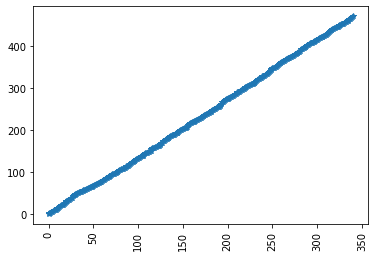

In [26]:
plt.plot(train_new['PhoneId'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [27]:
all_details = all_details.drop('PhoneId', axis =1)

In [28]:
all_details.head()

,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,Resolution,...,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,4,80.68,403,4000,182,1.8,6.26,157.9,64,20,...,0,0,0,1,0,0,0,0,0,0
1,3,80.85,271,4230,168,1.8,6.20,156.2,32,8,...,0,0,0,1,0,0,0,0,0,0
2,3,83.68,409,3500,168,2.1,6.30,157.0,32,25,...,0,0,0,1,0,0,0,0,0,0
3,4,74.78,411,3300,169,2.2,6.00,159.8,64,24,...,0,0,0,1,0,0,0,0,0,0
4,4,84.23,396,3750,175,2.2,6.50,160.4,64,16,...,0,0,0,1,0,0,0,0,0,0


72.35334310850443


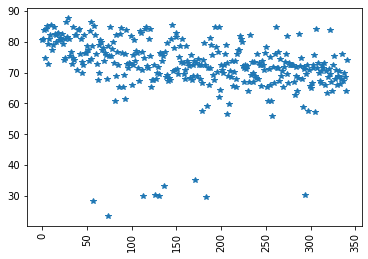

In [29]:
print(train_new['Screen to Body Ratio (calculated)'].mean())
plt.plot(train_new['Screen to Body Ratio (calculated)'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [30]:
all_details['Screen to Body Ratio (calculated)'] = all_details['Screen to Body Ratio (calculated)'].map(lambda x: 0 if x <= 72.35 else 1)

In [31]:
test_new['Screen to Body Ratio (calculated)'] = test_new['Screen to Body Ratio (calculated)'].map(lambda x: 0 if x<= 72.35 else 1)

5.4623167155425305


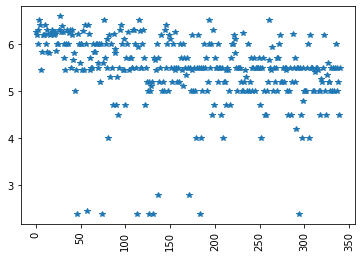

In [32]:
print(train_new['Screen Size'].mean())
plt.plot(train_new['Screen Size'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [33]:
all_details['Screen Size'] = all_details['Screen Size'].map(lambda x: 0 if x <= 5.46 else 1)

In [34]:
test_new['Screen Size'] = test_new['Screen Size'].map(lambda x: 0 if x<= 5.46 else 1)

1.7925513196480922


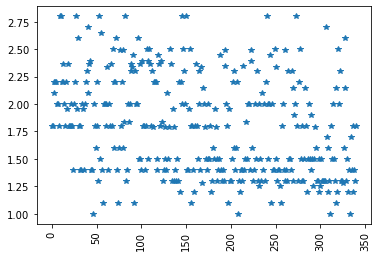

In [35]:
print(train_new['Processor_frequency'].mean())
plt.plot(train_new['Processor_frequency'].T,'*')
plt.xticks(rotation = 'vertical')
plt.show()

In [36]:
all_details['Processor_frequency'] = all_details['Processor_frequency'].map(lambda x: 0 if x <= 1.79 else 1)

In [37]:
test_new['Processor_frequency'] = test_new['Processor_frequency'].map(lambda x: 0 if x <= 1.76 else 1)

11.120234604105573


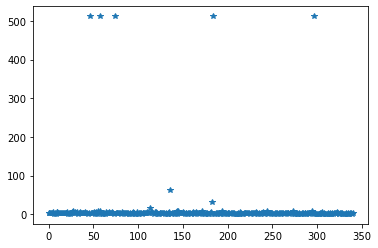

In [38]:
print(train_new['RAM'].mean())
plt.plot(train_new['RAM'].T,'*')
plt.show()

In [39]:
all_details['RAM'] = all_details['RAM'].map(lambda x: 0 if x <= 1 else 1)

In [40]:
test_new['RAM'] = test_new['RAM'].map(lambda x: 0 if x <= 1 else 1)

In [41]:
print(train_new['Internal Memory'].value_counts())

32     111
64      93
16      78
128     26
8       22
4        5
256      4
512      1
0        1
Name: Internal Memory, dtype: int64


46.36950146627566


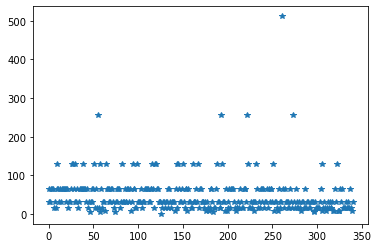

In [42]:
print(train_new['Internal Memory'].mean())
plt.plot(train_new['Internal Memory'],'*')
plt.show()

In [43]:
all_details['Internal Memory'] = all_details['Internal Memory'].map(lambda x: 0 if x<=32 else 1)

In [44]:
test_new['Internal Memory'] = test_new['Internal Memory'].map(lambda x: 0 if x <= 32 else 1)

In [45]:
print(train_new['Weight'].value_counts())

161    44
150    14
143    12
160    12
170    10
       ..
196     1
199     1
207     1
211     1
58      1
Name: Weight, Length: 83, dtype: int64


161.34310850439883


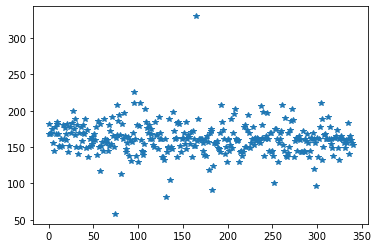

In [46]:
print(train_new['Weight'].mean())
plt.plot(train_new['Weight'],'*')
plt.show()

In [47]:
all_details['Weight'] = all_details['Weight'].map(lambda x: 0 if x<= 160 else 1)

In [48]:
test_new['Weight'] = test_new['Weight'].map(lambda x:0 if x<= 160 else 1)

8     103
5     101
16     45
2      22
13     19
20     17
7      13
24     12
25      8
12      1
Name: Resolution, dtype: int64
8.0


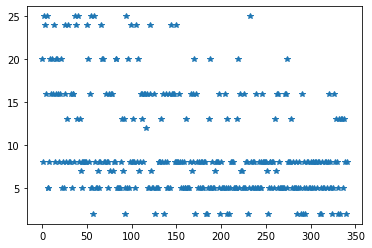

In [49]:
print(train_new['Resolution'].value_counts())
print(train_new['Resolution'].median())
plt.plot(train_new['Resolution'],'*')
plt.show()

In [50]:
all_details['Resolution'] = all_details['Resolution'].map(lambda x: 0 if x<=7 else 1)

In [51]:
test_new['Resolution'] = test_new['Resolution'].map(lambda x:0 if x<=7 else 1)

401    43
294    33
282    27
295    17
403    17
       ..
306     1
310     1
344     1
355     1
490     1
Name: Pixel Density, Length: 69, dtype: int64
344.21114369501464
326.0


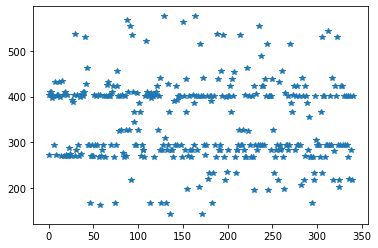

In [52]:
print(train_new['Pixel Density'].value_counts())
print(train_new['Pixel Density'].mean())
print(train_new['Pixel Density'].median())
plt.plot(train_new['Pixel Density'],'*')
plt.show()

In [53]:
all_details['Pixel Density'] = all_details['Pixel Density'].map(lambda x:0 if x<=326 else 1)

In [54]:
test_new['Pixel Density'] = test_new['Pixel Density'].map(lambda x:0 if x<= 326 else 1)

149.946394    11
153.000000     7
151.700000     6
157.500000     6
148.000000     6
              ..
144.200000     1
123.800000     1
142.800000     1
159.900000     1
141.600000     1
Name: Height, Length: 161, dtype: int64
149.94639393939403
151.3


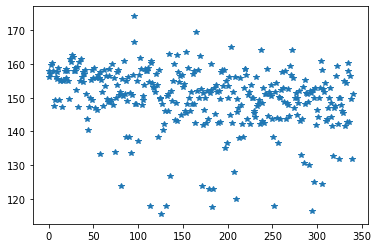

In [55]:
print(train_new['Height'].value_counts())
print(train_new['Height'].mean())
print(train_new['Height'].median())
plt.plot(train_new['Height'],'*')
plt.show()

In [56]:
all_details['Height'] = all_details['Height'].map(lambda x: 0 if x<= 150 else 1)

In [57]:
test_new['Height'] = test_new['Height'].map(lambda x: 0 if x<= 150 else 1)

3000    63
4000    46
3300    16
3500    13
2000    10
        ..
5020     1
1700     1
2150     1
2470     1
2050     1
Name: Capacity, Length: 86, dtype: int64
3191.307917888563
3055.0


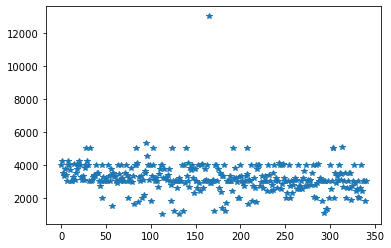

In [58]:
print(train_new['Capacity'].value_counts())
print(train_new['Capacity'].mean())
print(train_new['Capacity'].median())
plt.plot(train_new['Capacity'],'*')
plt.show()

In [59]:
all_details['Capacity'] = all_details['Capacity'].map(lambda x: 0 if x<=3000 else 1)

In [60]:
test_new['Capacity'] = test_new['Capacity'].map(lambda x: 0 if x<=3000 else 1)

In [61]:
all_details.head(20)

,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,Resolution,...,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
5,1,1,1,1,0,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
6,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,1,1,1,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,1,1,0,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,0,0,0,0,0


In [62]:
test_new.head(20)

,PhoneId,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,...,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,3,1,1,0,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,11,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
2,13,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3,16,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,19,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
5,24,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
6,25,1,1,1,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
7,27,1,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,29,1,1,0,1,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,0
9,32,1,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
testphoneid = test_new['PhoneId']

In [64]:
test_new = test_new.drop('PhoneId',axis =1)

In [65]:
test_new.head(20)

,RAM,Screen to Body Ratio (calculated),Pixel Density,Capacity,Weight,Processor_frequency,Screen Size,Height,Internal Memory,Resolution,...,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,1,1,0,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
5,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
6,1,1,1,1,1,1,1,1,0,1,...,0,0,0,1,0,0,0,0,0,0
7,1,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,1,1,0,1,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
9,1,1,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [66]:
all_details = all_details.values
test_new = test_new.values


In [67]:
ratings = ratings.values

In [68]:
all_details.shape

(341, 86)

In [69]:
test_new.shape

(119, 86)

In [70]:
ratings.shape

(341,)

In [71]:
b = 3
i = 30
print("for row ", i)
if (np.sum(all_details[i,:]) >= b):
    print("MP Neuron inference is liked")
else:
    print("MP Neuron inference is not like")

if (ratings[i] == 1):
    print("ground result is liked")
else:
    print("ground result is not liked")

for row  30
MP Neuron inference is liked
ground result is not liked


In [72]:
b = 8

Y_Pred_Train = []
accurate_rows = 0

# iterate 2 vectors simultaneously so for that I'll use zip function
for x, y in zip(all_details, ratings):
    Y_Pred = (np.sum(x) >= b)    # inference of the model
    Y_Pred_Train.append(Y_Pred)
    accurate_rows += (y == Y_Pred)

print(accurate_rows, accurate_rows/all_details.shape[0])

210 0.6158357771260997


In [73]:
for b in range(all_details.shape[1] + 1):
    Y_Pred_Train = []
    accurate_rows = 0

  # iterate 2 vectors simultaneously so for that I'll use zip function
    for x, y in zip(all_details, ratings):
        Y_Pred = (np.sum(x) >= b)    # inference of the model
        Y_Pred_Train.append(Y_Pred)
        accurate_rows += (y == Y_Pred)

    print(b, accurate_rows/all_details.shape[0])

0 0.5865102639296188
1 0.5865102639296188
2 0.5865102639296188
3 0.5865102639296188
4 0.5865102639296188
5 0.5865102639296188
6 0.5865102639296188
7 0.6099706744868035
8 0.6158357771260997
9 0.6334310850439883
10 0.6480938416422287
11 0.6480938416422287
12 0.656891495601173
13 0.6217008797653959
14 0.5689149560117303
15 0.5483870967741935
16 0.501466275659824
17 0.41348973607038125
18 0.41348973607038125
19 0.41348973607038125
20 0.41348973607038125
21 0.41348973607038125
22 0.41348973607038125
23 0.41348973607038125
24 0.41348973607038125
25 0.41348973607038125
26 0.41348973607038125
27 0.41348973607038125
28 0.41348973607038125
29 0.41348973607038125
30 0.41348973607038125
31 0.41348973607038125
32 0.41348973607038125
33 0.41348973607038125
34 0.41348973607038125
35 0.41348973607038125
36 0.41348973607038125
37 0.41348973607038125
38 0.41348973607038125
39 0.41348973607038125
40 0.41348973607038125
41 0.41348973607038125
42 0.41348973607038125
43 0.41348973607038125
44 0.413489736070

In [74]:
class MPNeuron:
  
    def __init__(self):
        self.b = None
    
    def model(self, x):
        return(sum(x) >= self.b)
  
    def predict(self, X):
        Y = []
        for x in X:
            result = self.model(x)
            Y.append(result)
        return np.array(Y)
  
    def fit(self, X, Y):
        accuracy = {}
    
        for b in range(X.shape[1] + 1):
            self.b = b
            Y_pred = self.predict(X)
            accuracy[b] = accuracy_score(Y_pred, Y)

        best_b = max(accuracy, key = accuracy.get)
        self.b = best_b

        print('Optimal value of b is', best_b)
        print('Highest accuracy is', accuracy[best_b])

In [75]:
mp_neuron = MPNeuron()
mp_neuron.fit(all_details, ratings)

Optimal value of b is 12
Highest accuracy is 0.656891495601173


In [76]:
Y_testPred = mp_neuron.predict(test_new)

In [77]:
Y_testPred = Y_testPred.astype(int)

# Submission

In [78]:
submission = pd.DataFrame({'PhoneId':testphoneid, 'Class':Y_testPred})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,1
1,11,1
2,13,1
3,16,1
4,19,1


In [79]:
submission.to_csv("submission.csv", index=False)